# Multilayer perceptron using Keras in TensorFlow

This notebook shows an example of training and
testing a multi-class DNN (deep neural network; aka
a multilayer perceptron) model on the classic
MNIST image set. We use the keras portion of
TensorFlow to do this.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

# Print out the TensorFlow version to help others reproduce this notebook.
print(tf.__version__)

1.9.0


## Load in the data

Each input is a black and white (single channel)
image of size 28x28. Each label (y-value) is an integer from 0 to 9.

Each pixel has type `uint8`; an integer in the range [0, 256).

This data format is explored and explained in a bit more detail
in the notebook for Koan 4.

In [2]:
mnist = keras.datasets.mnist

(X_train, y_train_), (X_test, y_test_) = mnist.load_data()

### Convert the data format

The multi-class categorical loss functions built-in to keras expect
the labels to be one-hot vectors. We perform the corresponding
conversion using numpy alone;
another approach would be to use keras'
[`to_categorical()`](https://keras.io/utils/#to_categorical) function.

In [3]:
# Convert the labels to one-hot vectors.
y_train = np.eye(10)[y_train_]
y_test  = np.eye(10)[y_test_]

# Sanity check.
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

## Set up the keras model

This model consists of 10
densely-connected hidden layers followed by a final
softmax layer. The hidden layers each contain 32 units,
except for the first, which contains 64. The intuition
behind this choice (more units per layer earlier in the model)
is that we don't expect the first
layer to necessarily fully learn very complex features,
whereas later units, in some sense, have more power to
work with more advanced features, so perhaps we will
need fewer units per layer to capture the information
needed for classification.

To be clear, this model receives each image as a kind of
"ordered bag of pixels," in the sense that the image is
flattened, and there is not really any explicit information
provided about which pixels are next to which other pixels.
However, each pixel value in
the flattened input vector always comes from the same location
in the image (from the same $(x, y)$ coordinate), so that
geometric information *can* be learned by the model, but it
is more work for the model than it would be for a convolutional
model (a CNN; see koan 6).

In [4]:
layers = keras.layers

model = keras.Sequential()

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
for _ in range(9):
    model.add(layers.Dense(32, activation='relu'))
    
model.add(layers.Dense(10, activation='softmax'))

model.compile(
    optimizer = tf.train.AdamOptimizer(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [5]:
# Train the model.

n_epochs = 40
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0, validation_split=0.2)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
__________

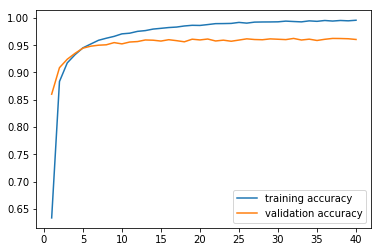

In [7]:
# Plot the training and validation accuracy over time.

epochs = range(1, n_epochs + 1)

plt.plot(epochs, history.history['acc'], label='training accuracy')
plt.plot(epochs, history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

These curves show a little bit of overfitting.

# Compute the test-set accuracy

In [8]:
results = model.evaluate(X_test, y_test)

print()
print('Test accuracy:')
print(results[1])

10000/10000 [==============================] - 0s 23us/step

Test accuracy:
0.9587


# See if dropout helps

We'll add overfitting after each hidden dense layer as
an attempt to reduce overfitting. Let's see how that
works.

In [9]:
layers = keras.layers

model2 = keras.Sequential()

model2.add(layers.Flatten())

model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.05))
for _ in range(9):
    model2.add(layers.Dense(32, activation='relu'))
    model2.add(layers.Dropout(0.05))
    
model2.add(layers.Dense(10, activation='softmax'))

model2.compile(
    optimizer = tf.train.AdamOptimizer(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:
# Train the model.

n_epochs = 40
history = model2.fit(X_train, y_train, epochs=n_epochs, verbose=0, validation_split=0.2)

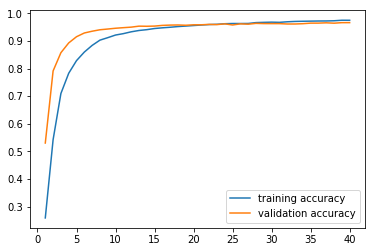

In [11]:
# Plot the training and validation accuracy over time.

epochs = range(1, n_epochs + 1)

plt.plot(epochs, history.history['acc'], label='training accuracy')
plt.plot(epochs, history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [12]:
# Check the test accuracy for this model.

results = model2.evaluate(X_test, y_test)

print()
print('Test accuracy (with dropout):')
print(results[1])

10000/10000 [==============================] - 0s 27us/step

Test accuracy (with dropout):
0.9634


It's a little better!

The training curves also appear to show less overfitting.

## Examine some mistakes made

It can be instructive to take a look at errors
the model makes. We'll get the indexes of all
the errors on the test set, and take a look at
a random subset of these.

In [13]:
# Find all the places in the test set where the model
# predicts the wrong class. The boolean != operator here
# results in an array of True/False values, and the
# np.flatnonzero() call converts that to the indexes
# where the value is True.

predicted_classes = model.predict_classes(X_test)

mistakes = np.flatnonzero(predicted_classes != y_test_)
len(mistakes)

413

In [14]:
# Choose a random subset of mistakes that we'll display.

nrows, ncols = 2, 4

show_idx = np.random.choice(
    np.arange(len(mistakes)),
    size = nrows * ncols,
    replace = False
)
show_idx = mistakes[show_idx]

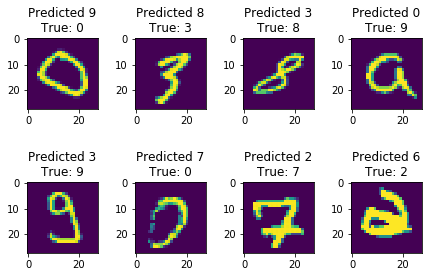

In [16]:
# Render and label the random mistakes.

plt.subplots(nrows, ncols)
plt.tight_layout(pad=0.0)

for i, pt_idx in enumerate(show_idx):
    
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(X_test[pt_idx])
    fmt = 'Predicted %d\nTrue: %d'
    title = fmt % (predicted_classes[pt_idx], y_test_[pt_idx])
    plt.title(title)
    
plt.show()

I can understand these errors, although some of them
seem strange to me, such as the 0 that is misclassified as
an 9.

# Summary

So far among these koans, we have the following test accuracies for
the MNIST dataset:

* Multi-class SVM: 89.05%
* Basic DNN (here): 96.34%

This model is doing a much better job than the SVM.

(You may see a slightly different value on your run since
models are randomly initialized each time.)